# Examen Unidad 2

**Integrantes**

Acosta López Roberto Ismael - 18111958 \
Gaytan Bañuelos Ángel - 18111893 \
Valenzuela Rodriguez Axel Alejandro - 18111978 

## Importando librerias

Importamos las librerias que utilizaremos para todo el documento

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer


## Cargando Dataset

### Información sobre el dataset
# Poner algo aqui 

lo que dice en kaggle es lo siguiente: 
Firma electrónica de préstamo basada en historial financiero
Desarrolle un modelo para predecir si el solicitante completó o no el proceso de firma electrónica

Contenido:-
El archivo contiene detalles de usuario que están dispuestos a completar el proceso de firma

Detalles:-
Excepto todas las columnas, la columna de clase denota lo siguiente: -
Clase 0 --> No completó el proceso de firma
clase 1 --> Proceso de firma electrónica completado.

Meta:-
El objetivo principal es crear varios algoritmos diferentes y predecir si el solicitante completó el proceso de firma electrónica o no.

Método de resolución: -
La declaración del problema dada se encuentra bajo clasificación binaria.
Tenemos que resolver el problema utilizando diferentes algoritmos de aprendizaje automático, así como algoritmos de aprendizaje profundo.

In [5]:
df = pd.read_csv('Financial-Data.csv')

## Capitulo 5 - Entendiendo los datos

### Verificar los datos

In [6]:
df.head()

,ID,Edad,Fecha_de_salario,Dueño_de_casa,Ingreso,Meses_trabajados,Años_trabajados,Años_en_vivienda_actual,Cuenta_personal_meses,Cuenta_personal_años,...,Cantidad_solicitada,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Firma_electronica
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,...,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,...,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,...,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


### Dimensionando los datos

In [7]:
df.shape

(17908, 21)

### Tipos de datos

In [8]:
df.dtypes

ID                           int64
Edad                         int64
Fecha_de_salario            object
Dueño_de_casa                int64
Ingreso                      int64
Meses_trabajados             int64
Años_trabajados              int64
Años_en_vivienda_actual      int64
Cuenta_personal_meses        int64
Cuenta_personal_años         int64
Tiene_deuda                  int64
Cantidad_solicitada          int64
risk_score                   int64
risk_score_2               float64
risk_score_3               float64
risk_score_4               float64
risk_score_5               float64
ext_quality_score          float64
ext_quality_score_2        float64
consultas_el_mes_pasado      int64
Firma_electronica            int64
dtype: object

### Descripción estadística

In [9]:
df.describe()

,ID,Edad,Dueño_de_casa,Ingreso,Meses_trabajados,Años_trabajados,Años_en_vivienda_actual,Cuenta_personal_meses,Cuenta_personal_años,Tiene_deuda,Cantidad_solicitada,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Firma_electronica
count,1.790800e+04,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,5.596978e+06,43.015412,0.425173,3657.214653,1.186006,3.526860,3.584711,3.427183,3.503350,0.795399,950.446449,61086.302211,0.690878,0.878276,0.583155,0.718252,0.623112,0.622068,6.457226,0.538251
std,2.562473e+06,11.873107,0.494383,1504.890063,2.400897,2.259732,2.751937,2.216440,1.955568,0.403421,698.543683,15394.255020,0.090470,0.054563,0.125061,0.120697,0.139729,0.139898,3.673093,0.498549
min,1.111398e+06,18.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.023258,0.451371,0.016724,0.153367,0.010184,0.006622,1.000000,0.000000
25%,3.378999e+06,34.000000,0.000000,2580.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,0.640993,0.850882,0.500208,0.633708,0.521735,0.519677,4.000000,0.000000
50%,5.608376e+06,42.000000,0.000000,3260.000000,0.000000,3.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,0.699561,0.881004,0.588208,0.725113,0.625944,0.622973,6.000000,1.000000
75%,7.805624e+06,51.000000,1.000000,4670.000000,1.000000,5.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,0.752887,0.912608,0.672395,0.806681,0.729841,0.728940,8.000000,1.000000
max,9.999874e+06,96.000000,1.000000,9985.000000,11.000000,16.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,0.999997,0.999024,0.978932,0.996260,0.970249,0.966953,30.000000,1.000000


### Distribución de clases

In [12]:
conteo_df = df.groupby("Firma_electronica").size()
conteo_df

Firma_electronica
0    8269
1    9639
dtype: int64

1: Proceso de firma electrónica completado \
0: No completado el proceso de firma electrónica

### Correlación entre características

In [14]:
correlacion = df.corr(method="pearson")
correlacion

,ID,Edad,Dueño_de_casa,Ingreso,Meses_trabajados,Años_trabajados,Años_en_vivienda_actual,Cuenta_personal_meses,Cuenta_personal_años,Tiene_deuda,Cantidad_solicitada,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Firma_electronica
ID,1.000000,0.004333,0.002528,-0.009034,0.015546,-0.000950,-0.001701,-0.000515,-0.007721,0.007476,0.001720,0.006780,0.013761,-0.005550,0.006963,0.004949,0.006025,0.006392,-0.003492,0.002735
Edad,0.004333,1.000000,0.142046,0.174062,-0.103635,0.182590,0.146554,-0.013609,0.041332,-0.043808,0.084132,0.162868,-0.019163,0.111258,0.069191,0.093710,0.032265,0.040019,0.041224,-0.096998
Dueño_de_casa,0.002528,0.142046,1.000000,0.147487,0.018008,0.027367,0.179291,0.013782,-0.047105,-0.076206,0.033996,0.113608,0.000647,0.049708,-0.137293,-0.080470,0.010080,0.005507,0.011215,-0.047409
Ingreso,-0.009034,0.174062,0.147487,1.000000,-0.049157,0.102139,0.046982,0.009052,-0.002002,-0.011199,0.289099,0.168375,-0.023627,0.058665,-0.001254,0.025179,-0.008429,-0.003323,0.051622,0.031377
Meses_trabajados,0.015546,-0.103635,0.018008,-0.049157,1.000000,-0.189805,-0.056609,0.211605,-0.019645,-0.000546,-0.044234,-0.044765,0.028950,-0.024297,-0.014512,-0.019406,-0.009041,-0.004461,-0.026710,0.010128
Años_trabajados,-0.000950,0.182590,0.027367,0.102139,-0.189805,1.000000,0.343905,-0.052543,0.184879,0.005293,0.084841,0.098960,-0.056574,0.074659,-0.029398,0.000234,0.014162,0.030353,0.011976,0.003748
Años_en_vivienda_actual,-0.001701,0.146554,0.179291,0.046982,-0.056609,0.343905,1.000000,0.082491,0.110258,0.017423,0.067893,0.090535,-0.060412,0.058936,-0.161052,-0.094545,0.003362,0.009093,0.013659,-0.018969
Cuenta_personal_meses,-0.000515,-0.013609,0.013782,0.009052,0.211605,-0.052543,0.082491,1.000000,-0.140649,0.246832,-0.046148,-0.044146,-0.023498,0.029162,-0.060695,-0.033960,-0.016151,-0.009181,-0.028225,-0.081195
Cuenta_personal_años,-0.007721,0.041332,-0.047105,-0.002002,-0.019645,0.184879,0.110258,-0.140649,1.000000,-0.030701,0.051857,0.017071,0.027535,0.079175,0.012877,0.042121,0.039808,0.029372,0.003923,-0.024160
Tiene_deuda,0.007476,-0.043808,-0.076206,-0.011199,-0.000546,0.005293,0.017423,0.246832,-0.030701,1.000000,-0.008445,-0.020332,-0.034691,0.001108,0.002074,0.002341,-0.021523,-0.009055,-0.001007,0.039192


## Capitulo 6 - Visualizando los datos

### Histograma

In [17]:
colores = ["red", "blue","orange", "green", "purple", "pink", "brown", "yellow", "cyan"]
def histograma(data):
    numero_color = df.columns.get_loc(data.name)
    plt.hist(x=data, histtype="stepfilled", color=colores[numero_color], label= data.name, align="mid" )
    cadena = 'Número de ' + data.name
    plt.title('Histograma de ' + str(data.name))
    plt.xlabel(cadena)
    plt.legend()
    plt.xlim(0, (data.max() + 1))
    plt.ylabel('Número de mujeres')
    plt.show()

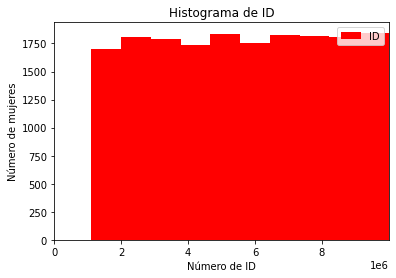

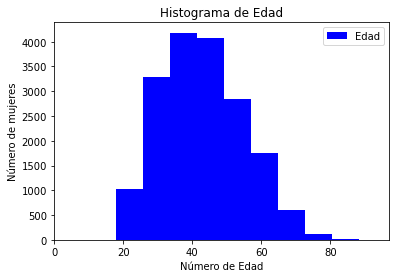

TypeError: can only concatenate str (not "int") to str

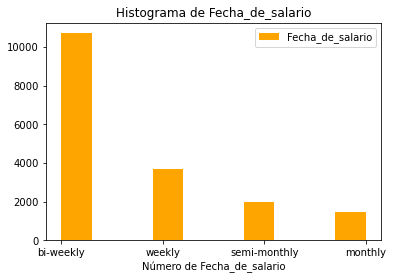

In [18]:
df.drop.apply(histograma)

## Capitulo 7 - Procesamiento de los datos

## Capitulo 8 - Seleccionando características

## Capitulo 9 - Algoritmos de clasificación ( todavia no es seguro usarlo )

## Capitulo 10 - Métricas de rendimiento algoritmos de clasificación  

## Capitulo 11 - Algoritmos de regresión  ( Todavia no es seguro que lo usaremos)

## Capitulo 12 - Métricas de rendimiento algoritmos de regresión 

## Capitulo 13 - Proyecto - Clasificación 

## Capitulo 14 - Proyecto - Regresión 

## Capitulo 15 y 16 no son importantes